# Term 1 - Lane Detection using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minise chances of collisions with other cars due to lane misalignment.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. Some of those techniques will be covered below.

This is the first project of the Term 1 of the [Udacity Self Driving Car Engineer Nanodegree](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013). 

# Loading Original Images

Our first step is to load the test images and visualise them.

In [148]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Making sure we import our images with the right names
test_img_dir = "test_images/"
original_image_names = os.listdir(test_img_dir)
original_image_names.remove(".DS_Store")
original_image_names = list(map(lambda name: test_img_dir + name, original_image_names))
print(original_image_names)

['test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/video_challenge_0s.jpg', 'test_images/video_challenge_1s.jpg', 'test_images/video_challenge_2s.jpg', 'test_images/video_challenge_4s.jpg', 'test_images/video_challenge_5s.jpg', 'test_images/video_challenge_6s.jpg', 'test_images/video_yellow_lane_left_12s.jpg', 'test_images/video_yellow_lane_left_13s.jpg', 'test_images/video_yellow_lane_left_3s.jpg', 'test_images/whiteCarLaneSwitch.jpg']


In [149]:
# Convenience function used to show a list of images
def show_image_list(img_list, cols=2, fig_size=(15, 15), img_labels=original_image_names):
    img_count = len(img_list)
    rows = img_count / cols
    cmap = None
    plt.figure(figsize=fig_size)
    for i in range(0, img_count):
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        img = img_list[i]
        if len(img.shape) < 3:
            cmap = "gray"
        plt.title(img_name[len(test_img_dir):])    
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

Total image count:  14


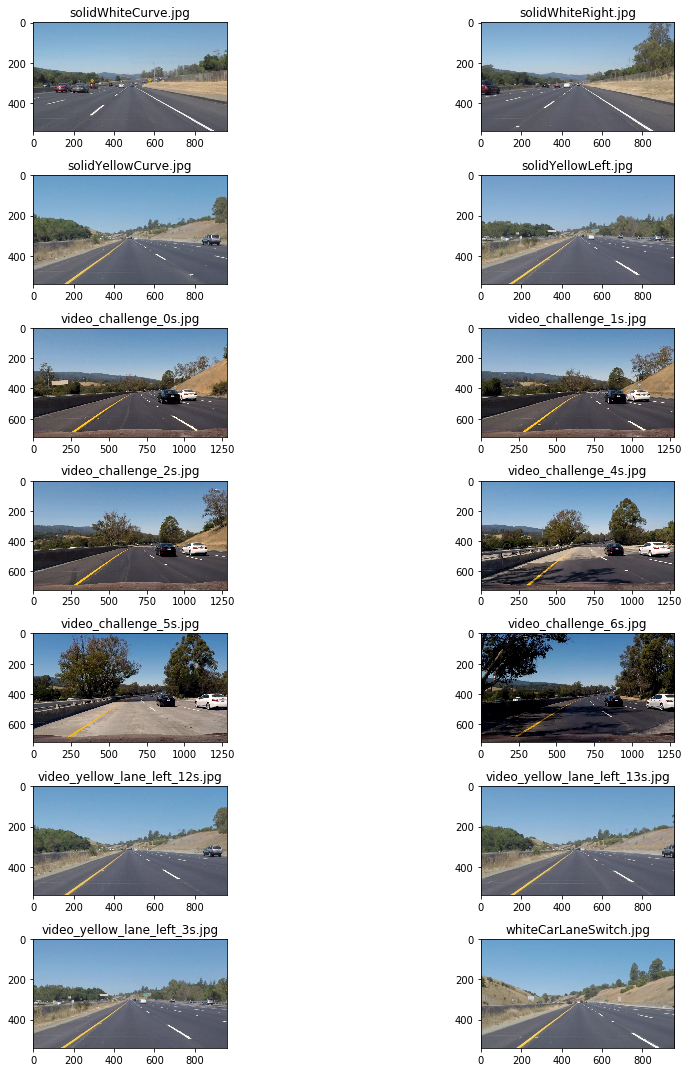

In [150]:
original_images = list(map(lambda img_name: mpimg.imread(img_name), original_image_names))
print("Total image count: ", len(original_images))
show_image_list(original_images)

Let's print the dimensions of one of our images

In [151]:
img_shape = original_images[0].shape
img_shape

(540, 960, 3)

The above shows an image of height width x height of 960 x 540 (this order is reversed in the call to `shape` above). The 3 at the end indicates that we are dealing with a color image where the 3 channels are simply the RGB channels.

# Pipeline 

In this part, we will cover in detail the different steps needed to create our pipeline, which will enable us to identify and classify lane lines. The pipeline itself will look as follows:
* Convert image to grayscale for easier manipulation
* Apply Gaussian Blur to smoothen edges
* Apply Canny Edge Detection on smoothed gray image
* Trace Region Of Interest and discard all other lines identified by our previous step that are outside this region
* Perform a Hough Transform to find lanes within our region of interest and trace them in red
* Separate left and right lanes
* Extrapolate them to create two smooth lines 

## Convert to Grayscale

We are interested in detecting white or yellow lines on images, which show a particularly high contrast when the image is in grayscale. Remember that the road is black, so anything that is much brighter on the road will come out with a high contrast in a grayscale image 

In [152]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

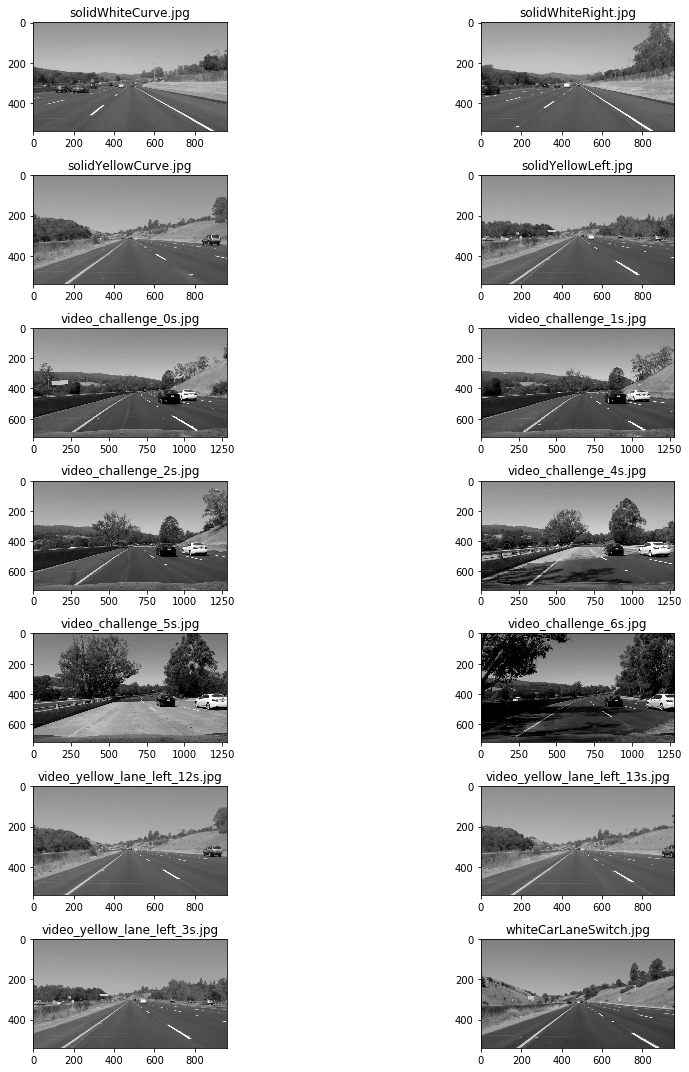

In [153]:
grayscale_images = list(map(lambda img: grayscale(img), original_images))
show_image_list(grayscale_images)

As stated above, colored lane lines contrast highly with the black of the road.

## Gaussian Blur

[Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) (also refered to as Gaussian smoothing) is a pre-processing technique used to smoothen the edges of an image to reduce noise.
The images below show what a typical Gaussian blur does to an image:
<figure>
 <img src="https://upload.wikimedia.org/wikipedia/commons/6/62/Cappadocia_Gaussian_Blur.svg" width="380" height="300" alt="Gaussian Blur" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Original image against Gaussian blurred variants </p> 
 </figcaption>
</figure>

It is possible to choose the intensity of the blur by specifying a *kernel* parameter, which is an odd number.

In [154]:
def gaussian_blur(grayscale_img, kernel_size=3):
    return cv2.GaussianBlur(grayscale_img, (kernel_size, kernel_size), 0) 

We will show how different blurs affect the image

In [155]:
blurred_images1 = list(map(lambda img: gaussian_blur(img, kernel_size=5), grayscale_images))
blurred_images2 = list(map(lambda img: gaussian_blur(img, kernel_size=11), grayscale_images))
blurred_images3 = list(map(lambda img: gaussian_blur(img, kernel_size=21), grayscale_images))

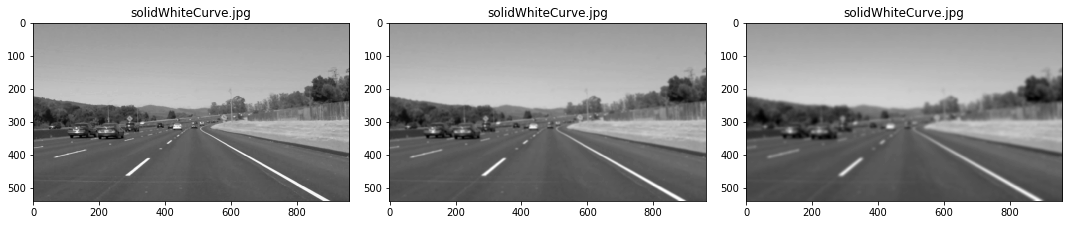

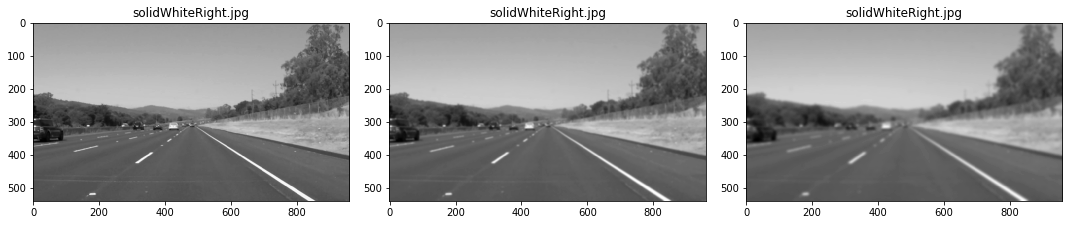

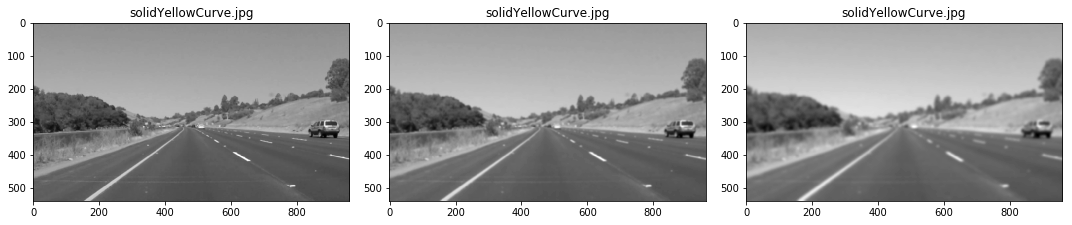

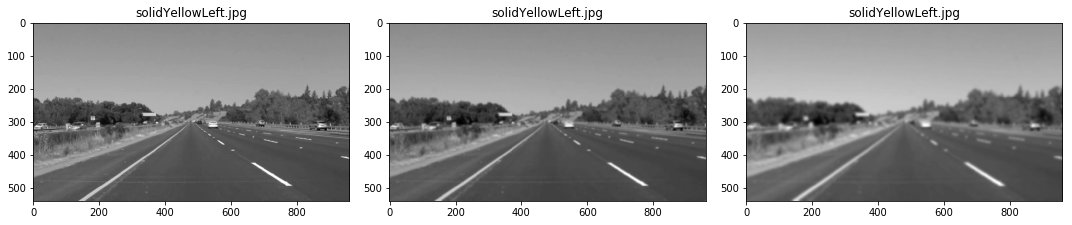

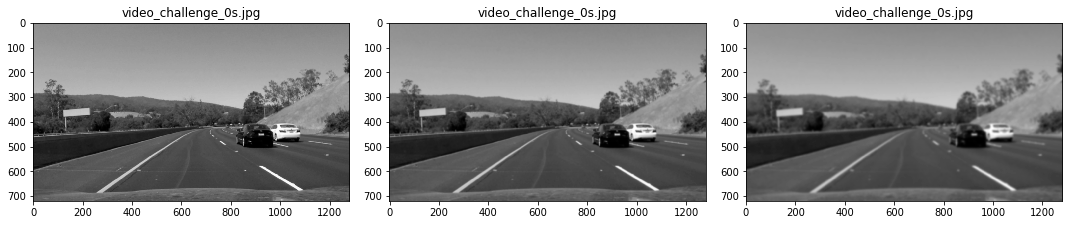

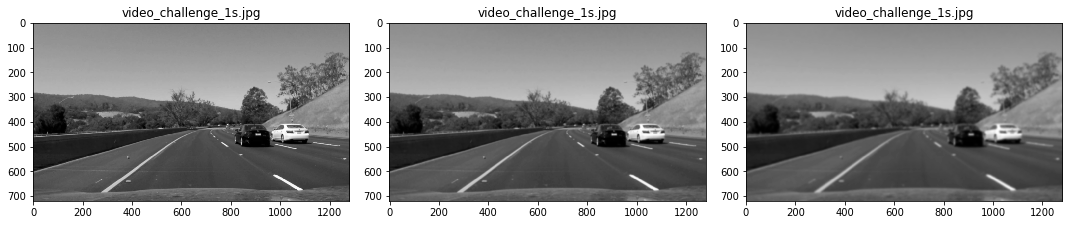

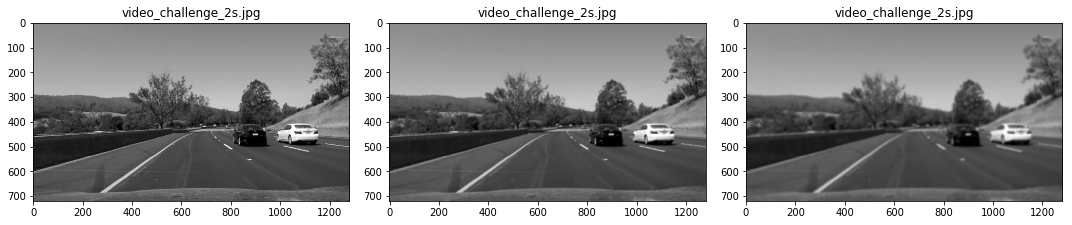

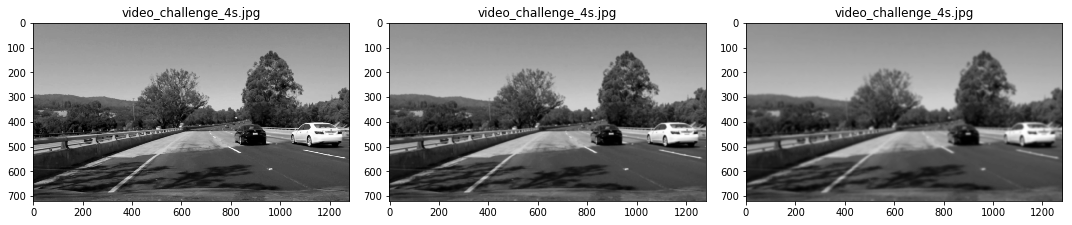

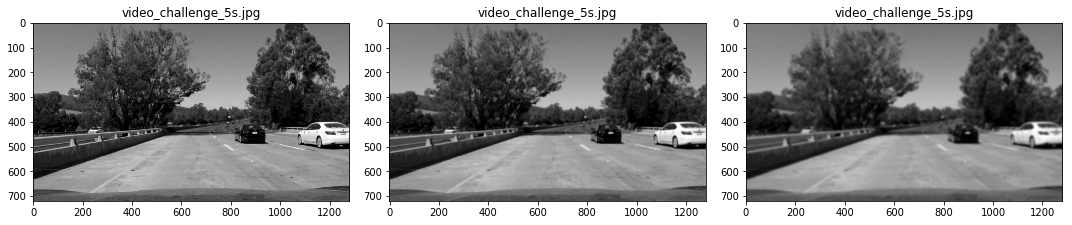

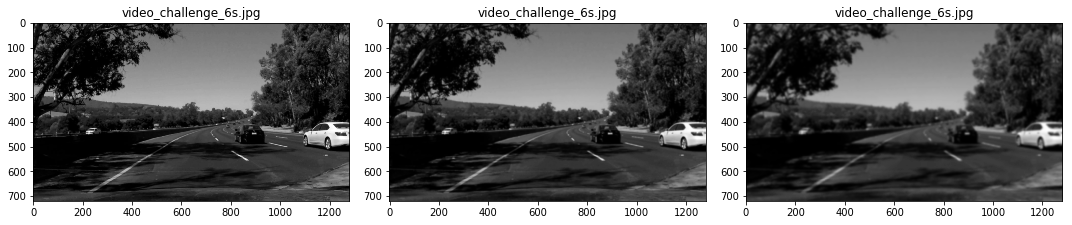

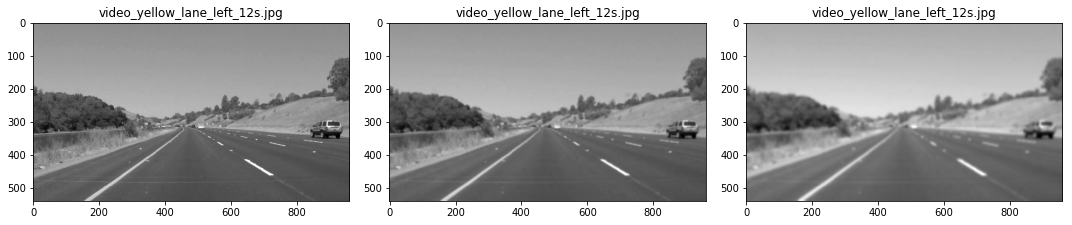

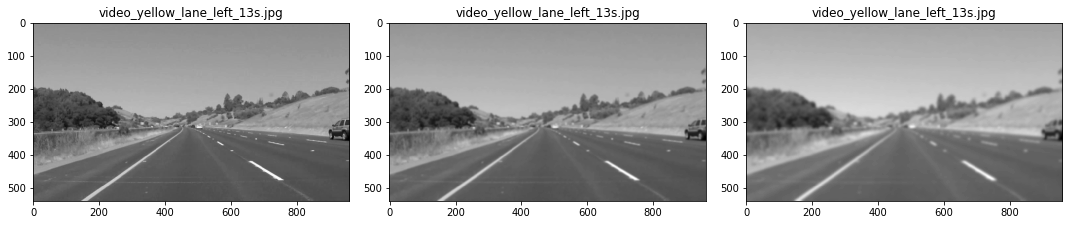

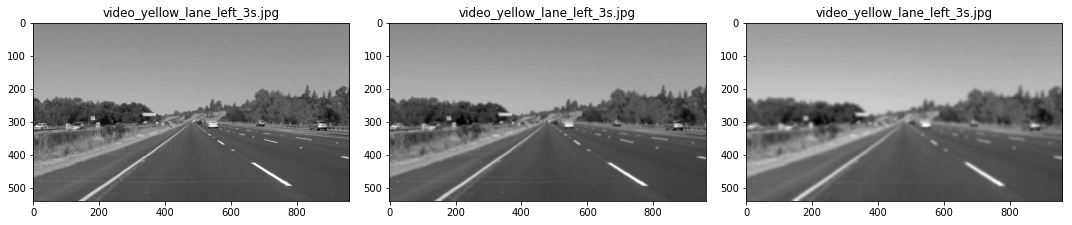

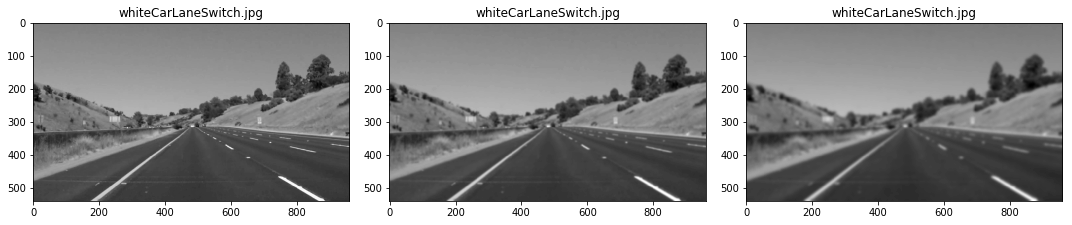

In [156]:
img_count = len(blurred_images1)
interleaved_blur = list(zip(blurred_images1, blurred_images2, blurred_images3))

k = 0
for blurs in interleaved_blur:
    img_name = original_image_names[k]
    show_image_list(blurs, cols=3, fig_size=(15, 15), img_labels=[img_name, img_name, img_name] )
    k += 1

We can see how increasing the kernel makes the image more blurry. For our task, we will choose a kernel size of 5 for our gaussian blur (images on the left).

## Canny Edge Detection

Now that we have sufficiently pre-processed the image, we can apply a [Canny Edge Detector](https://en.wikipedia.org/wiki/Canny_edge_detector), whose role it is to identify lines in an image and discard all other data. The resulting image ends up being _wiry_, which enables us to focus on lane detection even more, since we are concerned with lines.

The OpenCV implementation requires passing in two parameters in addition to our blurred image, a low and high threshold which determine whether to include a given edge or not. A threshold captures the intensity of change of a given point (you can think of it as a gradient). Any point beyond the high threshold will be included in our resulting image, while points between the threshold values will only be included if they are next to edges beyond our high threshold. Edges that are below our low threshold are discarded. Recommended low:high threshold rations are 1:3 or 1:2.

In [116]:
def canny_edge_detector(blurred_img, low_threshold, high_threshold):
    return cv2.Canny(blurred_img, low_threshold, high_threshold)

In [117]:
canny_images1 = list(map(lambda img: canny_edge_detector(img, 50, 150), blurred_images2)) 
canny_images2 = list(map(lambda img: canny_edge_detector(img, 0, 10), blurred_images2)) 
canny_images3 = list(map(lambda img: canny_edge_detector(img, 10, 50), blurred_images2)) 

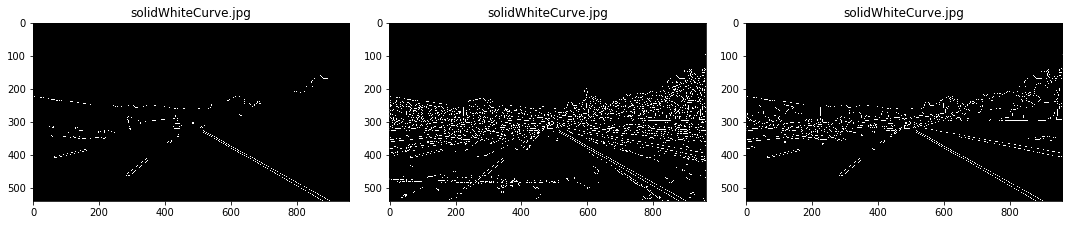

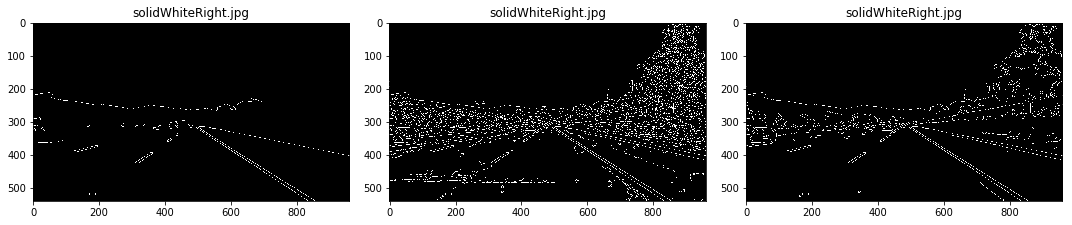

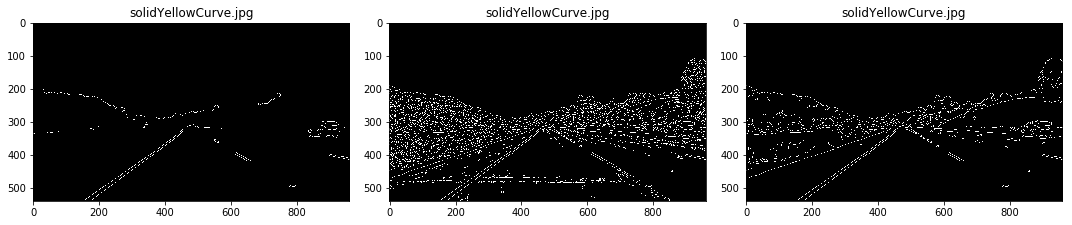

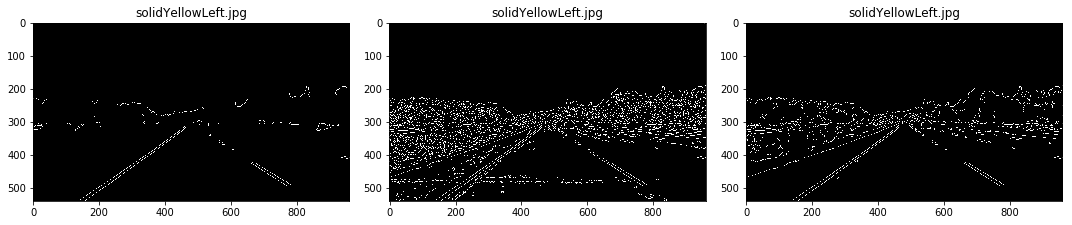

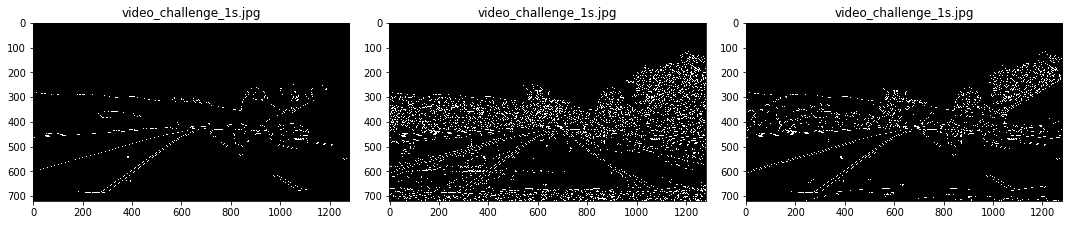

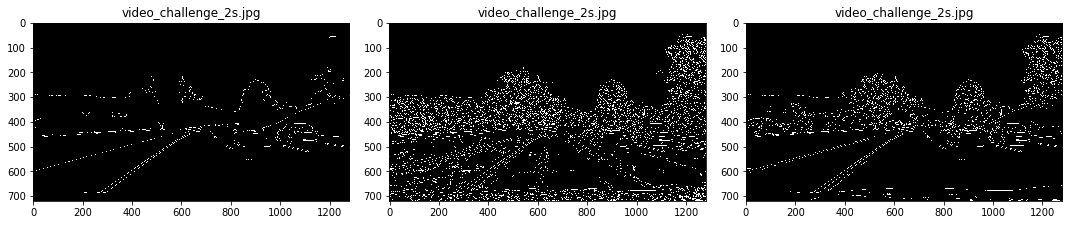

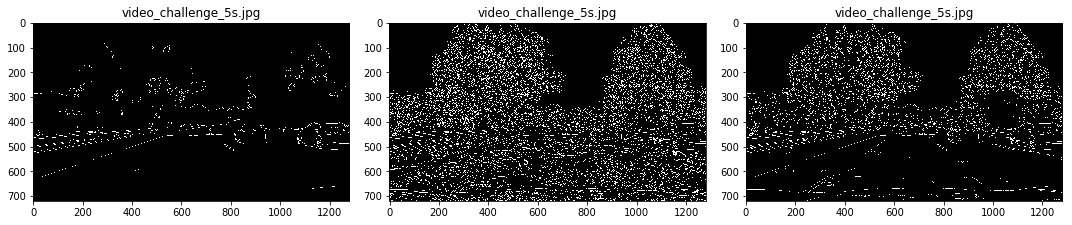

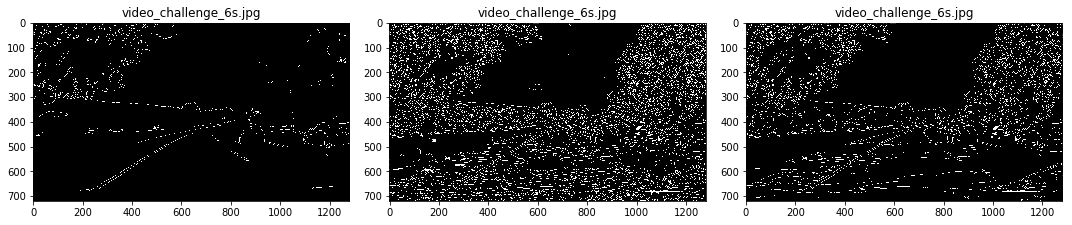

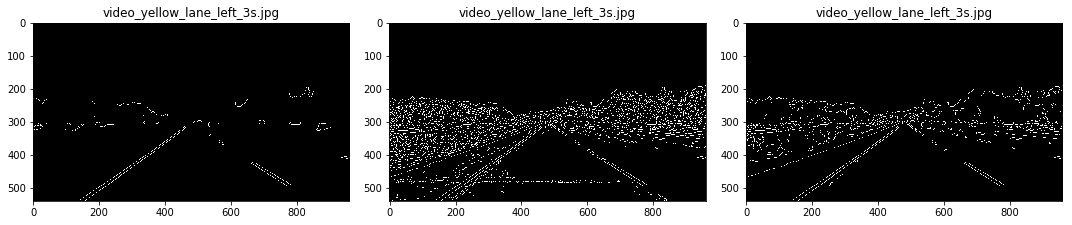

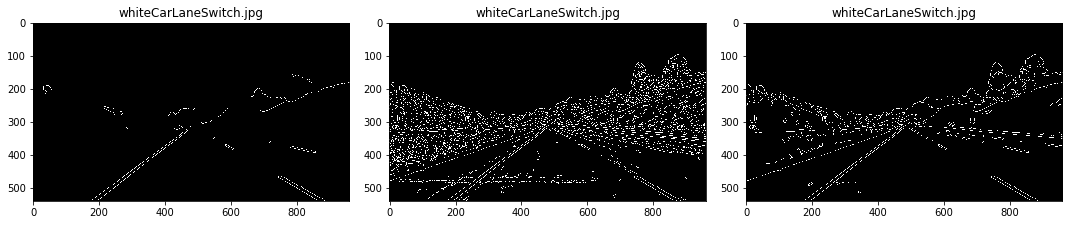

In [118]:
img_count = len(canny_images1)
interleaved_canny = list(zip(canny_images1, canny_images2, canny_images3))

k = 0
for cannys in interleaved_canny:
    img_name = original_image_names[k]
    show_image_list(cannys, cols=3, fig_size=(15, 15), img_labels=[img_name, img_name, img_name])
    k += 1

The above figure shows a images resulting from a canny detector process using different threshold parameters. Naturally, we will opt for the images with threshold parameters (50, 150) as they exhibit the least noise.

## Region Of Interest

Our next step is to determine a region of interest and discard any lines outside of this polygon. One crucial assumption in this task is that the camera remains in the sample place across all these image, and lanes are flat, therefore we can identify the critical region we are interested in.

Looking at the above images, we "guess" what that region may be by following the contours of the lanes the car is in and define a polygon which will act as our region of interest below.

In [280]:
def get_vertices_for_img(img):
    imshape = img.shape
    height = imshape[0]
    width = imshape[1]

    vert = None
    
    if (width, height) == (960, 540):
        region_bottom_left = (130 ,img_shape[0] - 1)
        region_top_left = (410, 330)
        region_top_right = (650, 350)
        region_bottom_right = (img_shape[1] - 30,img_shape[0] - 1)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)
    else:
        region_bottom_left = (200 , 680)
        region_top_left = (600, 450)
        region_top_right = (750, 450)
        region_bottom_right = (1100, 650)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)

    return vert

def region_of_interest(img):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
        
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vert = get_vertices_for_img(img)    
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vert, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [281]:
segmented_images = list(map(lambda img: region_of_interest(img), canny_images1))
canny_segmented_images = list(zip(canny_images1, segmented_images))

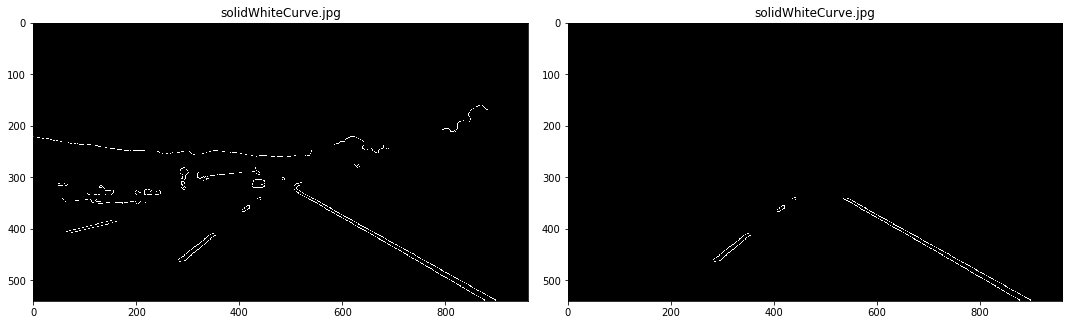

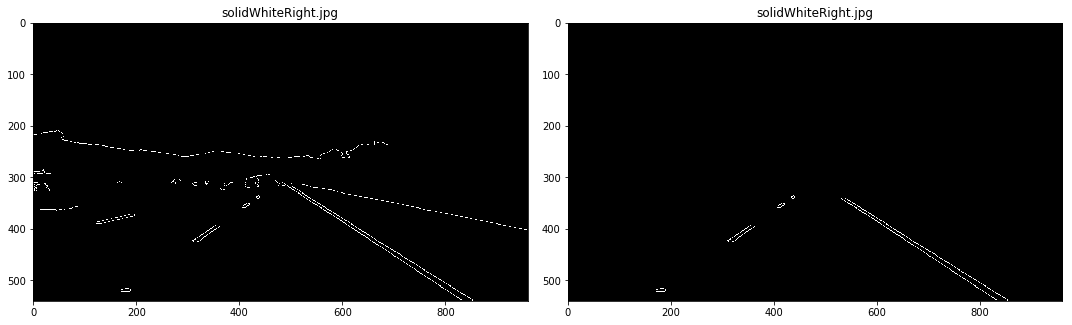

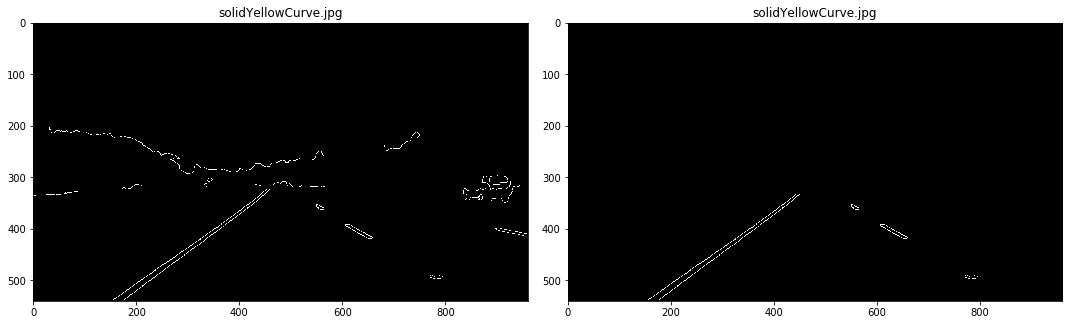

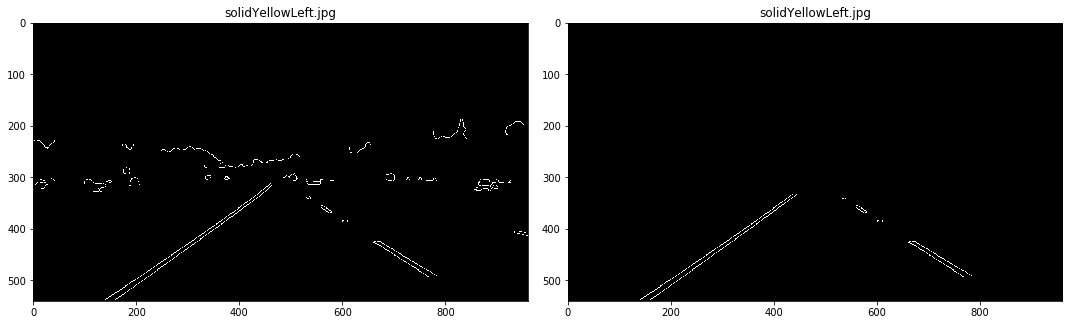

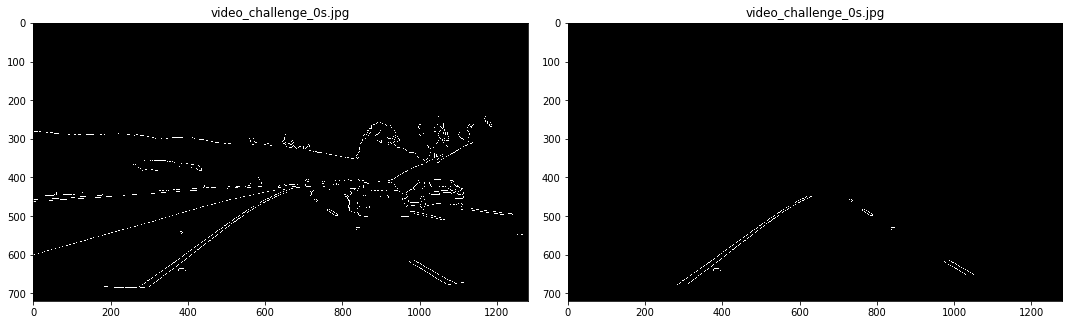

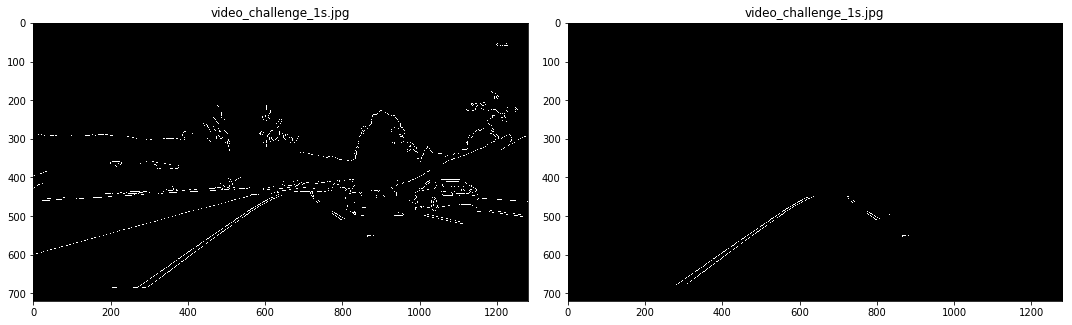

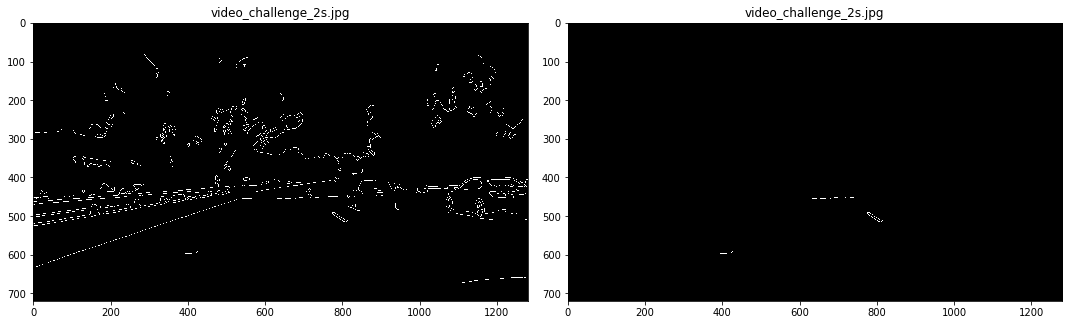

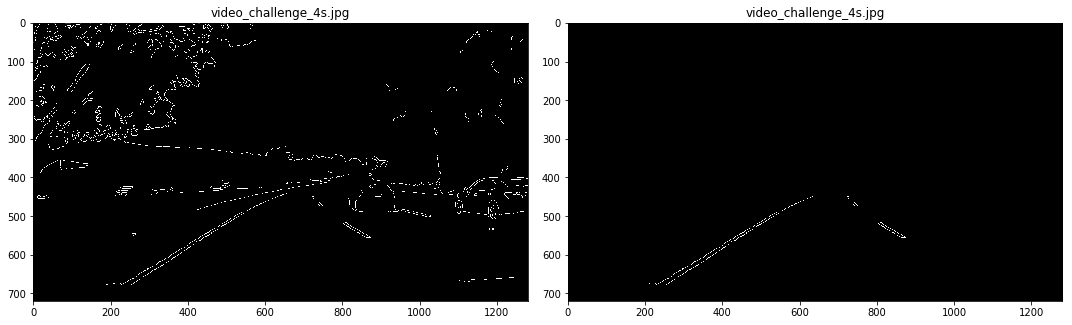

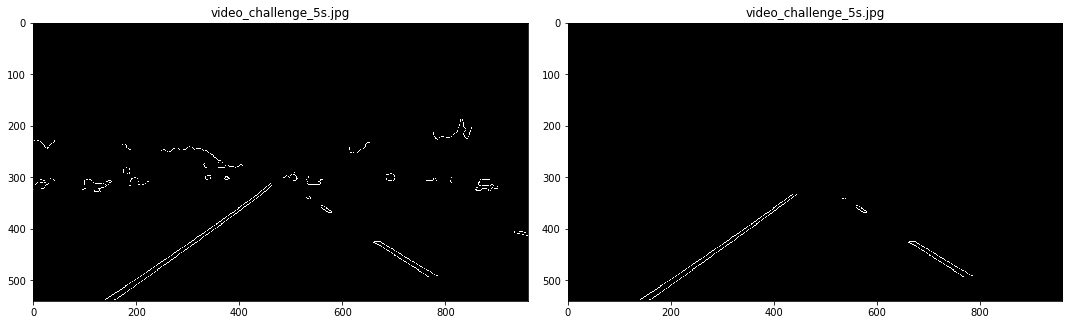

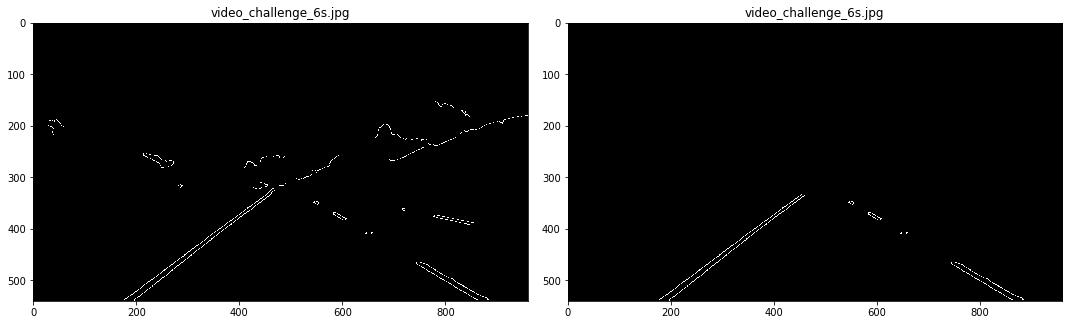

In [282]:
k = 0
for canny_segmented_img in canny_segmented_images: 
    img_name = original_image_names[k]
    show_image_list(canny_segmented_img, img_labels=[img_name, img_name])
    k += 1

## Hough Transform

The next step is to apply the [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform) technique to extract lines and color them. The goal of Hough Transform is to find lines by identifiying all points that lie on them. This is done by converting our current system denoted by axis (x,y) to a _parametric_ one where axes are (m, b). In this plane:
 * lines are represented as points
 * points are presented as lines (since they can be on many lines in traditional coordinate system)
 * intersecting lines means the same point is on multiple lines

Therefore, in such plane, we can more easily identify lines that go via the same point. We however need to move from the current system to a _Hough Space_ which uses _polar coordinates_ one as our original expression is not differentiable when m=0 (i.e. vertical lines). In polar coordinates, a given line will now be expressed as (ρ, θ), where line L is reachable by going a distance ρ at angle θ from the origin, thus meeting the perpendicular L; that is ρ = x cos θ + y sin θ. 
All straight lines going through a given point will correspond to a sinusoidal curve in the (ρ, θ) plane. Therefore, a set of points on the same straight line in Cartesian space will yield sinusoids that cross at the point (ρ, θ). This naturally means that the problem of detecting points on a line in cartesian space is reduced to finding intersecting sinusoids in Hough space.

<figure>
 <img src="docs/hough_and_cartesian_spaces.png" width="380" alt="Hough and Cartesian systems" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Hough and Cartesian systems</p> 
 </figcaption>
</figure>

The Hough transform algorithm implemented in OpenCV is described below (full documentation available [here](http://docs.opencv.org/trunk/d6/d10/tutorial_py_houghlines.html)): 

> Now let's see how the Hough Transform works for lines. Any line can be represented in these two terms, (ρ,θ). So first it creates a 2D array or accumulator (to hold the values of the two parameters) and it is set to 0 initially. Let rows denote the ρ and columns denote the θ. Size of array depends on the accuracy you need. Suppose you want the accuracy of angles to be 1 degree, you will need 180 columns. For ρ, the maximum distance possible is the diagonal length of the image. So taking one pixel accuracy, the number of rows can be the diagonal length of the image.

> Consider a 100x100 image with a horizontal line at the middle. Take the first point of the line. You know its (x,y) values. Now in the line equation, put the values θ=0,1,2,....,180 and check the ρ you get. For every (ρ,θ) pair, you increment value by one in our accumulator in its corresponding (ρ,θ) cells. So now in accumulator, the cell (50,90) = 1 along with some other cells.

> Now take the second point on the line. Do the same as above. Increment the values in the cells corresponding to (rho, theta) you got. This time, the cell (50,90) = 2. What you actually do is voting the (ρ,θ) values. You continue this process for every point on the line. At each point, the cell (50,90) will be incremented or voted up, while other cells may or may not be voted up. This way, at the end, the cell (50,90) will have maximum votes. So if you search the accumulator for maximum votes, you get the value (50,90) which says, there is a line in this image at a distance 50 from the origin and at angle 90 degrees. It is well shown in the below animation

<figure>
 <img src="docs/houghlines_demo.gif" width="380" alt="Hough Transform in action" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Hough Transform in Action</p> 
 </figcaption>
</figure>



The OpenCV Probabilistic Hough Transform requires the following parameters:
* ρ and θ for accuracy
* a threshold value which indicates the minimum number of votes to detect a line (i.e. how many intersecting sinusoidals)
* a minimum line length: shorter lines will be rejected by the algorithm
* a maximum line gap: maximum gap allowed between line segments to treat them as a single line

In [160]:
def hough_transform(canny_img, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

In [256]:
rho = 1
# 1 degree
theta = (np.pi/180) * 1
threshold = 15
min_line_length = 20
max_line_gap = 10

In [283]:
hough_lines_per_image = list(map(lambda img: hough_transform(img, rho, theta, threshold, min_line_length, max_line_gap), 
                                 segmented_images))

## Separating Left And Right Lanes

### Drawing Lines

Let's see what lines `hough_transform` function has identified:

In [258]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=15, make_copy=True):
    # Copy the passed image
    img_copy = np.copy(img) if make_copy else img
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
    
    return img_copy

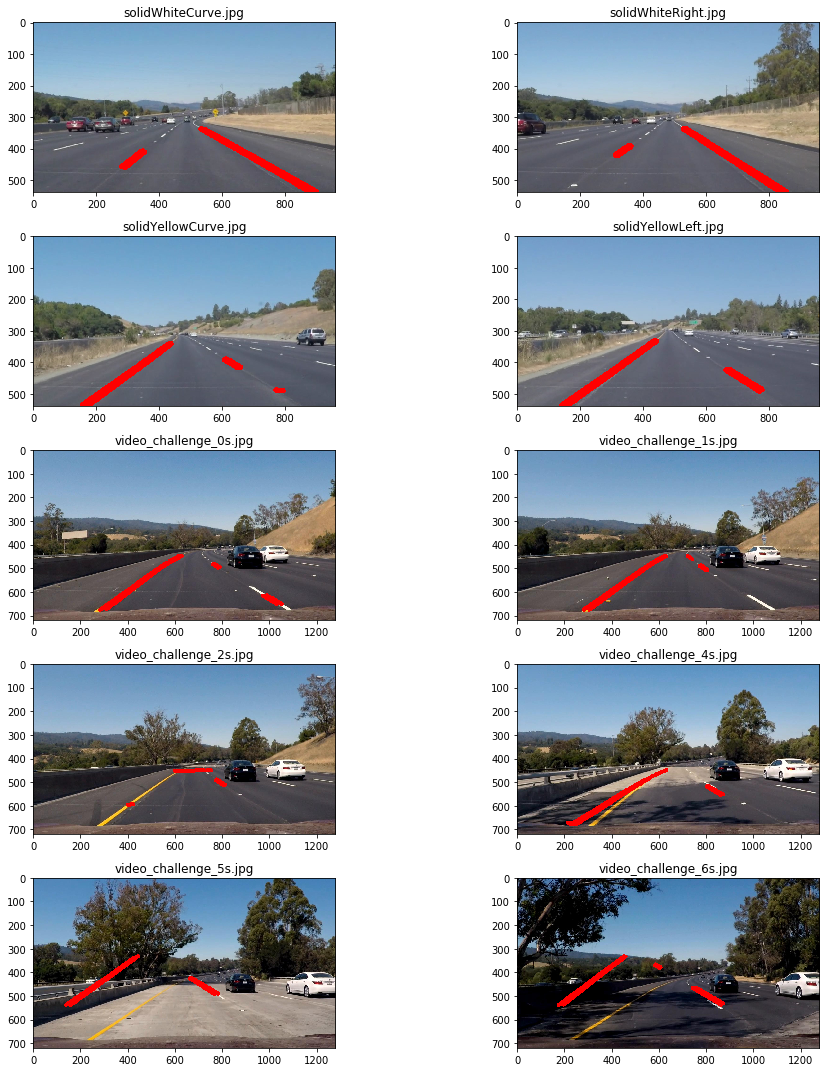

In [284]:
img_with_lines = list(map(lambda img, lines: draw_lines(img, lines), original_images, hough_lines_per_image))    
show_image_list(img_with_lines, fig_size=(15, 15))

The lanes are very clearly identified. There is one image where a small patch of lane has been rejected by the algorithm, due to the high threshold I specified. That's still ok as the bigger lane line was correctly identified.

### Separating Left And Right Lanes

To be able to trace a full line and connect lane markings on the image, we must be able to distinguish left from right lanes. Fortunately, there is a trivial way to do so. If you carefully look the image (may be easier with the canny segmented images), you can derive the gradient (i.e slope) of any left or right lane line:
* left lane: **as x value (i.e. width) increases, y value (i.e. height) decreases: slope must thus be negative**
* right lane:**as x value (i.e. width) increases, y value (i.e. height) increases: slope must thus be positive**

We can therefore define a function that separates lines into a left and right one

In [260]:
def separate_lines(lines, img):
    img_shape = img.shape
    
    middle_x = img_shape[1] / 2
    
    left_lane_lines = []
    right_lane_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            dx = x2 - x1 
            if dx == 0:
                #Discarding line since we can't gradient is undefined at this dx
                continue
            dy = y2 - y1
            
            # Similarly, if the y value remains constant as x increases, discard line
            if dy == 0:
                continue
            
            slope = dy / dx
            
            # This is pure guess than anything... 
            # but get rid of lines with a small slope as they are likely to be horizontal one
            epsilon = 0.1
            if abs(slope) <= epsilon:
                continue
            
            if slope < 0 and x1 < middle_x and x2 < middle_x:
                # Lane should also be within the left hand side of region of interest
                left_lane_lines.append([[x1, y1, x2, y2]])
            elif x1 >= middle_x and x2 >= middle_x:
                # Lane should also be within the right hand side of region of interest
                right_lane_lines.append([[x1, y1, x2, y2]])
    
    return left_lane_lines, right_lane_lines

In [285]:
separated_lanes_per_image = list(map(lambda lines, img: separate_lines(lines, img), hough_lines_per_image, original_images))

In [262]:
def color_lanes(img, left_lane_lines, right_lane_lines, left_lane_color=[255, 0, 0], right_lane_color=[0, 0, 255]):
    left_colored_img = draw_lines(img, left_lane_lines, color=left_lane_color, make_copy=True)
    right_colored_img = draw_lines(left_colored_img, right_lane_lines, color=right_lane_color, make_copy=False)
    
    return right_colored_img

In [286]:
img_different_lane_colors = list(map(lambda img, separated_lanes: color_lanes(img, separated_lanes[0], separated_lanes[1]), original_images, separated_lanes_per_image))

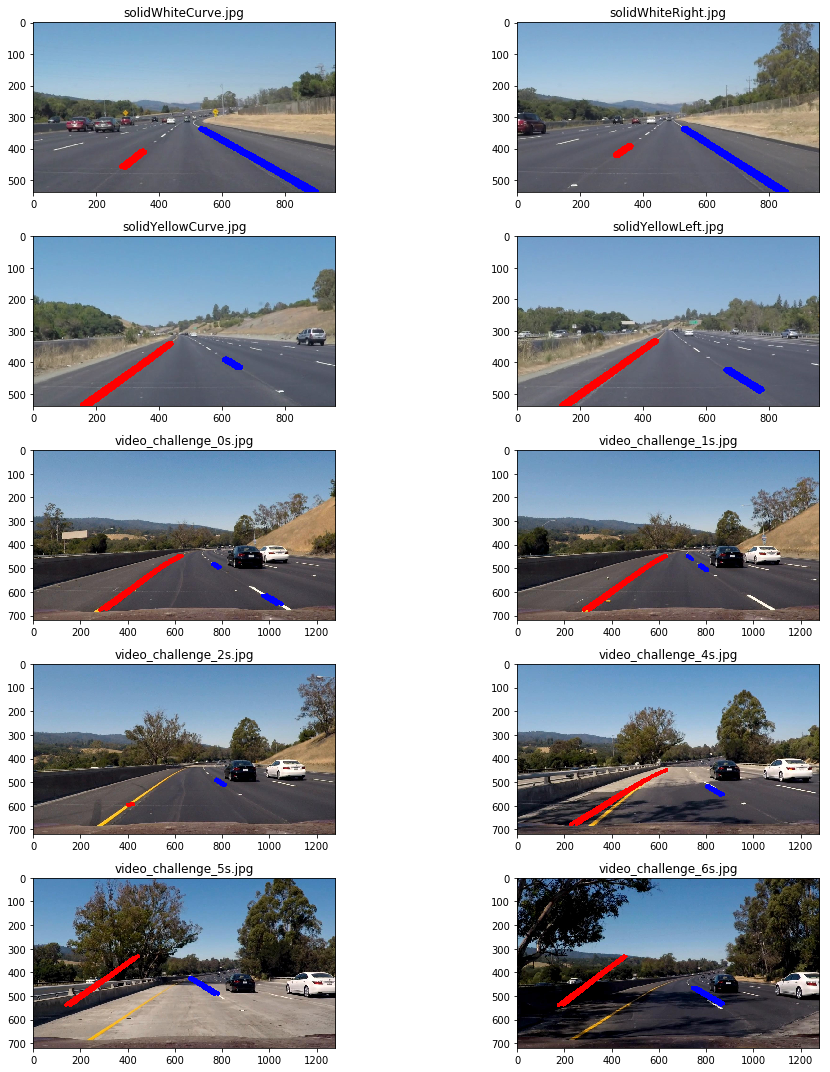

In [287]:
show_image_list(img_different_lane_colors)

As you can see above, left and right lanes are perfectly separated. 

### Lane Extrapolation

To trace a full line from the bottom of the screen to the highest point of our region of interest, we must be able to interpolate the different points on a given lane and find a line that minimise the distance across those points. Basically this is a [linear regression](https://en.wikipedia.org/wiki/Regression_analysis) problem. We will attempt to find the line on a given lane by minimising the [least squares](https://en.wikipedia.org/wiki/Least_squares) error.

In [195]:
from scipy import stats

def find_lane_lines_formula(lines):
    xs = []
    ys = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            xs.append(x1)
            xs.append(x2)
            ys.append(y1)
            ys.append(y2)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
    
    # Remember, a straight line is expressed as f(x) = Ax + b. Slope is the A, while intercept is the b
    return (slope, intercept)
    

We now define a function to trace a line on the lane:

In [288]:
def trace_lane_line(img, lines, top_y, make_copy=True):
    A, b = find_lane_lines_formula(lines)
    vert = get_vertices_for_img(img)

    img_shape = img.shape
    bottom_y = img_shape[0] - 1
    # y = Ax + b, therefore x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)

def trace_both_lane_lines(img, left_lane_lines, right_lane_lines):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line(img, left_lane_lines, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line(full_left_lane_img, right_lane_lines, region_top_left[1], make_copy=False)
    
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

In [289]:
full_lane_drawn_images = list(map(lambda img, separated_lanes : trace_both_lane_lines(img, separated_lanes[0], separated_lanes[1]), 
                                  original_images, separated_lanes_per_image))

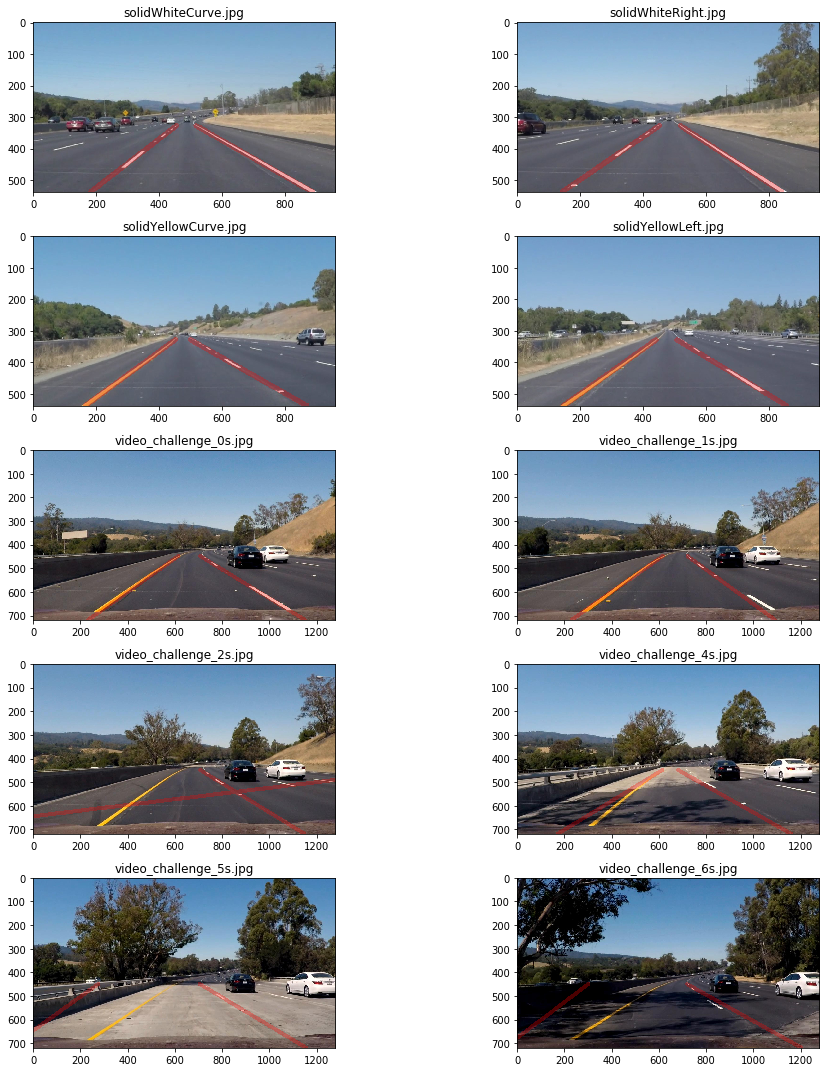

In [290]:
show_image_list(full_lane_drawn_images)

Both lines are very accurately detected and stop at roughly the same y value. We will now move on to detecting lane lines on video.

# Lane Detection On Videos

For this part, we read a video each frame at a time and modify the frame with the overlapping lines. Before, we get started, we must create a `pipeline` function that takes in a frame and returns the processed frame. 

## Lane Detector With Memory

A video is a sequence of frames. We can therefore use the information from previous frames to smoothen the lines that we trace on the road and take corrective steps if at frame t our computed lines differ disproportionately from the mean of line slopes and intercepts we computed from frames [0, t-1].

We therefore need to impart the concept of _memory_ into our pipeline. We will use a standard Python [_deque_](https://docs.python.org/2/library/collections.html#collections.deque) to store the last N computed line coefficients. One further step to explore would be to calculate the weighted average of these coefficients, giving a higher weight to more recent coefficients as they belong to more recent frames; I believe frame locality would play a critical role in getting near-perfect lines on video. 

In [136]:
from collections import deque

def create_lane_line_coefficients_list(length = 35):
    return deque(maxlen=length)

In [230]:
def trace_lane_line_with_coefficients(img, line_coefficients, top_y, make_copy=True):
    A = line_coefficients[0]
    b = line_coefficients[1]
    
    img_shape = img.shape
    bottom_y = img_shape[0] - 1
    # y = Ax + b, therefore x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)


def trace_both_lane_lines_with_lines_coefficients(img, left_line_coefficients, right_line_coefficients):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line_with_coefficients(img, left_line_coefficients, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line_with_coefficients(full_left_lane_img, right_line_coefficients, region_top_left[1], make_copy=False)
    
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

In [214]:
import math

MAXIMUM_SLOPE_DIFF = 2.0
MAXIMUM_INTERCEPT_DIFF = 100.0

class LaneDetectorWithMemory:
    def __init__(self):
        self.left_lane_coefficients  = create_lane_line_coefficients_list()
        self.right_lane_coefficients = create_lane_line_coefficients_list()
        
        self.previous_left_lane_coefficients = None
        self.previous_right_lane_coefficients = None
        
    
    def mean_coefficients(self, coefficients_queue, axis=0):        
        return [0, 0] if len(coefficients_queue) == 0 else np.mean(coefficients_queue, axis=axis)
    
    def determine_line_coefficients(self, stored_coefficients, current_coefficients):
        if len(stored_coefficients) == 0:
            stored_coefficients.append(current_coefficients) 
            return current_coefficients
        
        mean = self.mean_coefficients(stored_coefficients)
        abs_slope_diff = abs(current_coefficients[0] - mean[0])
        abs_intercept_diff = abs(current_coefficients[1] - mean[1])
        
        if abs_slope_diff > MAXIMUM_SLOPE_DIFF or abs_intercept_diff > MAXIMUM_INTERCEPT_DIFF:
            print("Identified big difference in slope (", current_coefficients[0], " vs ", mean[0],
                 ") or intercept (", current_coefficients[1], " vs ", mean[1], ")")
            # In this case use the mean
            return mean
        else:
            # Save our coefficients and returned a smoothened one
            stored_coefficients.append(current_coefficients)
            return self.mean_coefficients(stored_coefficients)
        

    def lane_detection_pipeline(self, img):
        grayscale_img = grayscale(img)
        gaussian_smoothed_img = gaussian_blur(grayscale_img, kernel_size=5)
        canny_img = canny_edge_detector(gaussian_smoothed_img, 50, 150)
        segmented_img = region_of_interest(canny_img)
        hough_lines = hough_transform(segmented_img, rho, theta, threshold, min_line_length, max_line_gap)

        try:
            left_lane_lines, right_lane_lines = separate_lines(hough_lines, img)
            left_lane_slope, left_intercept = find_lane_lines_formula(left_lane_lines)
            right_lane_slope, right_intercept = find_lane_lines_formula(right_lane_lines)
            smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [left_lane_slope, left_intercept])
            smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [right_lane_slope, right_intercept])
            img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
            return img_with_lane_lines

        except Exception as e:
            print("*** Error - will use saved coefficients ", e)
            smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [0.0, 0.0])
            smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [0.0, 0.0])
            img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
            return img_with_lane_lines


        #img_with_lane_lines = trace_both_lane_lines(img, left_lane_lines, right_lane_lines)
#        img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
 #       return img_with_lane_lines
    

## Solid White Lane Markings

This is the first test video, and arguably the easiest.

In [139]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [204]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
detector = LaneDetectorWithMemory()

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detector.lane_detection_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.08 s, sys: 895 ms, total: 3.97 s
Wall time: 7.6 s


In [205]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Yellow And White Lane Markings

This second video is slightly more tricky because of the yellow markings

In [202]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

#clip2.save_frame("test_images/video_yellow_lane_left_12s.jpg", t=12) # saves the frame
#clip2.save_frame("test_images/video_yellow_lane_left_13s.jpg", t=13) # saves the frame
#clip2.save_frame("test_images/video_yellow_lane_left_5s.jpg", t=5) # saves the frame
#clip2.save_frame("test_images/video_yellow_lane_left_6s.jpg", t=6) # saves the frame

detector = LaneDetectorWithMemory()
yellow_clip = clip2.fl_image(detector.lane_detection_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:21<00:00, 32.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.7 s, sys: 2.16 s, total: 11.9 s
Wall time: 22.1 s


In [203]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge Video

This one is hard as it contains slight curves on the road... 

The other complication I came across was that the dimension of this video are different from the previous two: each frame in this video is 1280 x 720, as opposed to 960 x 540 in other images. This means I had to re-evaluate the region of interest for frames of this video.

In [291]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

#clip3.save_frame("test_images/video_challenge_0s.jpg", t=0) # saves the frame
#clip3.save_frame("test_images/video_challenge_4s.jpg", t=4) # saves the frame

detector = LaneDetectorWithMemory()
challenge_clip = clip3.fl_image(detector.lane_detection_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 39%|███▉      | 99/251 [00:06<00:11, 12.97it/s]

Identified big difference in slope ( 0.241693967513  vs  0.590999435481 ) or intercept ( 305.398054922  vs  28.7625765872 )
Identified big difference in slope ( 0.319923304863  vs  0.590999435481 ) or intercept ( 247.50611818  vs  28.7625765872 )
Identified big difference in slope ( 0.299465510286  vs  0.590999435481 ) or intercept ( 262.846308996  vs  28.7625765872 )



 41%|████      | 103/251 [00:06<00:11, 12.63it/s]

Identified big difference in slope ( 0.0732316265725  vs  0.590999435481 ) or intercept ( 451.323141966  vs  28.7625765872 )
Identified big difference in slope ( 0.0565781989374  vs  0.586503710198 ) or intercept ( 479.836851065  vs  32.3896886505 )



 42%|████▏     | 105/251 [00:06<00:11, 12.22it/s]

Identified big difference in slope ( 0.224064199739  vs  0.586503710198 ) or intercept ( 348.525667107  vs  32.3896886505 )
Identified big difference in slope ( -0.387490945244  vs  -0.687967268029 ) or intercept ( 775.168388088  vs  883.979622127 )
Identified big difference in slope ( 0.0764573120185  vs  0.586503710198 ) or intercept ( 493.331538847  vs  32.3896886505 )
Identified big difference in slope ( -0.237613913447  vs  -0.687967268029 ) or intercept ( 732.508156323


 43%|████▎     | 109/251 [00:06<00:11, 12.35it/s]

  vs  883.979622127 )
Identified big difference in slope ( 0.0824504132682  vs  0.586503710198 ) or intercept ( 507.934977026  vs  32.3896886505 )
Identified big difference in slope ( -0.17487153315  vs  -0.687967268029 ) or intercept ( 723.751931806  vs  883.979622127 )
Identified big difference in slope ( 0.138790805842  vs  0.586503710198 ) or intercept ( 471.498793217  vs  32.3896886505 )
Identified big difference in slope ( 0.00837501155778  vs  0.586503710198 ) or intercept ( 598.301172703  vs  32.3896886505 )
Identified big difference in slope ( -0.013626793051  vs  -0.689764137122 ) or intercept ( 670.189186099  vs  884.465923419 )
Identified big difference in slope ( 0.0494931510426  vs  0.586503710198 ) or intercept ( 568.616910652  vs  32.3896886505 )



 44%|████▍     | 111/251 [00:07<00:10, 12.79it/s]

Identified big difference in slope ( 0.332780240456  vs  0.586503710198 ) or intercept ( 318.76013196  vs  32.3896886505 )
Identified big difference in slope ( 0.261318847855  vs  0.586503710198 ) or intercept ( 374.643833015  vs  32.3896886505 )
Identified big difference in slope ( -0.182215701087  vs  -0.696738871599 ) or intercept ( 696.019809402  vs  886.181541535 )
Identified big difference in slope ( 0.449804928183  vs  0.586503710198 ) or intercept ( 197.875657612  vs  32.3896886505 )



 46%|████▌     | 115/251 [00:07<00:09, 13.69it/s]

Identified big difference in slope ( -0.114081372183  vs  -0.696738871599 ) or intercept ( 683.100135413  vs  886.181541535 )
Identified big difference in slope ( 1.04788055603  vs  0.586503710198 ) or intercept ( -327.731130942  vs  32.3896886505 )
Identified big difference in slope ( -0.431232163421  vs  0.586503710198 ) or intercept ( 900.307840585  vs  32.3896886505 )
Identified big difference in slope ( -1.35252544289  vs  0.586503710198 ) or intercept ( 1620.33264229  vs  32.3896886505 )
Identified big difference in slope ( -0.333333333333  vs  -0.701391268887 ) or intercept ( 719.0  vs  887.512904824 )



 47%|████▋     | 119/251 [00:07<00:09, 13.74it/s]

Identified big difference in slope ( -0.199043584579  vs  -0.701391268887 ) or intercept ( 710.139449582  vs  887.512904824 )
Identified big difference in slope ( 0.335069937158  vs  0.58386544388 ) or intercept ( 262.089580377  vs  34.6074303639 )
Identified big difference in slope ( -0.389342365504  vs  -0.701391268887 ) or intercept ( 772.863861933  vs  887.512904824 )



 49%|████▉     | 123/251 [00:08<00:10, 11.75it/s]

*** Error - will use saved coefficients  Inputs must not be empty.
Identified big difference in slope ( 0.0  vs  -0.695771310716 ) or intercept ( 0.0  vs  884.397193412 )
Identified big difference in slope ( -0.3  vs  -0.695771310716 ) or intercept ( 678.1  vs  884.397193412 )
Identified big difference in slope ( -0.190476190476  vs  -0.695771310716 ) or intercept ( 629.80952381  vs  884.397193412 )



 51%|█████     | 127/251 [00:08<00:11, 11.22it/s]

Identified big difference in slope ( -0.195652173913  vs  -0.689525964081 ) or intercept ( 673.086956522  vs  880.654801258 )
Identified big difference in slope ( -0.111111111111  vs  -0.681074091033 ) or intercept ( 707.444444444  vs  877.311833612 )



 51%|█████▏    | 129/251 [00:08<00:10, 11.38it/s]

*** Error - will use saved coefficients  Inputs must not be empty.
Identified big difference in slope ( 0.0  vs  -0.681074091033 ) or intercept ( 0.0  vs  877.311833612 )



 56%|█████▌    | 141/251 [00:09<00:09, 11.99it/s]

Identified big difference in slope ( 0.735151214675  vs  0.55370585151 ) or intercept ( -80.0481903818  vs  34.7574149095 )
Identified big difference in slope ( 0.189217207431  vs  0.55370585151 ) or intercept ( 374.012055637  vs  34.7574149095 )



 57%|█████▋    | 143/251 [00:09<00:08, 12.63it/s]

Identified big difference in slope ( 0.374601811992  vs  0.552899865461 ) or intercept ( 226.047746091  vs  35.5650529566 )
Identified big difference in slope ( -0.808807834346  vs  -0.652983213382 ) or intercept ( 984.645007301  vs  854.657193303 )
Identified big difference in slope ( 0.376088740519  vs  0.554380429258 ) or intercept ( 236.607081382  vs  34.5072967309 )



 58%|█████▊    | 145/251 [00:09<00:09, 11.48it/s]

Identified big difference in slope ( -0.432608801674  vs  -0.647439321369 ) or intercept ( 740.806481618  vs  852.170836969 )
Identified big difference in slope ( 0.303017629633  vs  0.554380429258 ) or intercept ( 316.020949967  vs  34.5072967309 )
Identified big difference in slope ( 0.263502149394  vs  0.554380429258 ) or intercept ( 340.975412754  vs  34.5072967309 )



 59%|█████▊    | 147/251 [00:10<00:09, 11.06it/s]

Identified big difference in slope ( -0.631336892072  vs  0.554380429258 ) or intercept ( 1048.31645607  vs  34.5072967309 )
Identified big difference in slope ( -0.221995813784  vs  0.554380429258 ) or intercept ( 728.535012476  vs  34.5072967309 )



 60%|██████    | 151/251 [00:10<00:09, 10.90it/s]

Identified big difference in slope ( 0.149429013841  vs  0.554380429258 ) or intercept ( 458.645628587  vs  34.5072967309 )
Identified big difference in slope ( 0.465916155165  vs  0.554380429258 ) or intercept ( 200.594517294  vs  34.5072967309 )



 63%|██████▎   | 159/251 [00:11<00:08, 11.27it/s]

Identified big difference in slope ( 0.751195831503  vs  0.57737581548 ) or intercept ( -92.4279711814  vs  17.7096780177 )
Identified big difference in slope ( 0.751559863964  vs  0.57737581548 ) or intercept ( -93.5776852422  vs  17.7096780177 )



100%|██████████| 251/251 [00:18<00:00, 13.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.5 s, sys: 2.95 s, total: 9.45 s
Wall time: 20.8 s


In [292]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))